import zipfile
with zipfile.ZipFile('custom.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

import zipfile
with zipfile.ZipFile('./custom/s1.zip', 'r') as zip_ref:
    zip_ref.extractall('./custom/s1')

!pip install imutils pandas tensorflow --index-url https://infyartifactory.ad.infosys.com/artifactory/api/pypi/pypi-remote/simple --trusted-host infyartifactory.ad.infosys.com

In [566]:
# import the necessary packages
from imutils import build_montages
from imutils import paths
import numpy as np
import pandas as pd
import cv2
import os,random
from PIL import Image,ImageOps
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils.all_utils import Sequence
from keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from keras.models import Sequential
import warnings
from tqdm.notebook import tqdm
# for min pooling
from keras import backend as K
warnings.filterwarnings('ignore')

In [567]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def cv2_imshow(mat):
    plt.imshow(mat)

In [568]:
img1 = cv2.imread('./custom/full/001/001_00.png')
img1.shape

(359, 725, 3)

def make_pairs():
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    # loop over all images
    df = pd.read_csv('./custom/train_data.csv').sample(frac=0.01)
    path = './custom/full'
    for i in tqdm(range(len(df))):
        img1 = os.path.join(path, df.iloc[i, 0])
        img1 = Image.open(img1)
        img1 = img1.resize((725, 359))
        img1 = ImageOps.grayscale(img1)
        img1 = np.asarray(img1)/255.0
        img2 = os.path.join(path, df.iloc[i, 1])
        img2 = Image.open(img2)
        img2 = img2.resize((725, 359))
        img2 = ImageOps.grayscale(img2)
        img2 = np.asarray(img2)/255.0
        pairImages.append([img1, img2])
        pairLabels.append([df.iloc[i, 2]])
        
    return (np.array(pairImages), np.array(pairLabels))

def make_pairs_test():
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    # loop over all images
    df = pd.read_csv('./custom/test_data.csv').sample(frac=0.01)
    path = './custom/full'
    for i in tqdm(range(len(df))):
        img1 = os.path.join(path, df.iloc[i, 0])
        img1 = Image.open(img1)
        img1 = img1.resize((725, 359))
        img1 = ImageOps.grayscale(img1)
        img1 = np.asarray(img1)/255.0
        img2 = os.path.join(path, df.iloc[i, 1])
        img2 = Image.open(img2)
        img2 = img2.resize((725, 359))
        img2 = ImageOps.grayscale(img2)
        img2 = np.asarray(img2)/255.0
        pairImages.append([img1, img2])
        pairLabels.append([df.iloc[i, 2]])
        
    return (np.array(pairImages), np.array(pairLabels))

# build the positive and negative image pairs
print("[INFO] preparing positive and negative pairs...")
(pairTest, labelTest) = make_pairs_test()

# build the positive and negative image pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs()
#(pairTrain, labelTrain)[0]
#images = []
print('Prepared')

In [569]:
# specify the shape of the inputs for our network
IMG_SHAPE = (359,725,1)
# specify the batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 5

In [570]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, csv_path,
                 batch_size,
                 shuffle=True):
        
        self.df = pd.read_csv(csv_path).sample(frac=0.75)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.path = './custom/full'
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, x):
    
        img1 = os.path.join(self.path, x)
        img1 = Image.open(img1)
        img1 = img1.resize((725, 359))
        img1 = ImageOps.grayscale(img1)
        img1 = np.asarray(img1)/255.0
        
        return img1
    
    def __get_data(self, batches):
        X_1 = np.array([self.__get_input(x) for x, y,z in batches.to_numpy()])
        X_2 = np.array([self.__get_input(y) for x, y,z in batches.to_numpy()])          
        y_batch = np.array([z for x, y,z in batches.to_numpy()])

        return X_1,X_2,y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        x1,x2,y = self.__get_data(batches)
        return [x1,x2],y
    
    def __len__(self):
        return self.n // self.batch_size

In [571]:
# define the path to the base output directory
BASE_OUTPUT = "./output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [572]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [573]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)

    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    # return the computed contrastive loss to the calling function
    return loss

In [574]:
def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

    plt.savefig(plotPath)

In [575]:
def build_siamese_model(inputShape, embeddingDim=60):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(32, (2, 2), padding="same", activation="relu")(inputs)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(32, (2, 2), padding="same", activation="relu")(x)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    # Third set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x =-K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    # fourth set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    # fifth set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(128, (2, 2), padding="same", activation="relu")(x)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    # sixth set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(128, (2, 2), padding="same", activation="relu")(x)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    # seventh set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(512, (2, 2), padding="same", activation="relu")(x)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    # Eighth set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(512, (2, 2), padding="same", activation="relu")(x)
	x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
  # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [ ]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
model.compile(loss='binary_crossentropy', optimizer="adam",#contrastive_loss
    metrics=["accuracy"])
# train the model
print("[INFO] training model...")

training_generator = CustomDataGen('./custom/train_data.csv',BATCH_SIZE)
validation_generator = CustomDataGen('./custom/val_data.csv',BATCH_SIZE)

# Generators
history = model.fit(training_generator,
                    validation_data=validation_generator,epochs=EPOCHS
                    ,batch_size=BATCH_SIZE
                    )

# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history,PLOT_PATH)

[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/5
380/380 [==============================] - 258s 677ms/step - loss: 0.6913 - accuracy: 0.5382 - val_loss: 0.6903 - val_accuracy: 0.5409
Epoch 2/5
380/380 [==============================] - 255s 670ms/step - loss: 0.6900 - accuracy: 0.5401 - val_loss: 0.6897 - val_accuracy: 0.5413
Epoch 4/5
380/380 [==============================] - 256s 673ms/step - loss: 0.6900 - accuracy: 0.5400 - val_loss: 0.6900 - val_accuracy: 0.5394
Epoch 5/5
380/380 [==============================] - 254s 667ms/step - loss: 0.6900 - accuracy: 0.5402 - val_loss: 0.6901 - val_accuracy: 0.5390
[INFO] saving siamese model...
INFO:tensorflow:Assets written to: ./output/siamese_model/assets
[INFO] plotting training history...


In [ ]:
path = './custom/full'

fold = random.choice(os.listdir(path)).replace('_forg','')

org_fold = os.listdir(os.path.join(path,str(fold)))

forg_fold = os.listdir(os.path.join(path,str(fold) + '_forg'))

org1 = os.path.join(path,str(fold), random.choice(org_fold))
org2 = os.path.join(path,str(fold), random.choice(org_fold))

forg = os.path.join(path,str(fold) + '_forg', random.choice(forg_fold))


imageA = cv2.imread(org1, 0)
imageB = cv2.imread(org2, 0)

origA = imageA.copy()
origB = imageB.copy()

# add a batch dimension to both images
imageA = np.expand_dims(imageA, axis=0)
imageB = np.expand_dims(imageB, axis=0)

# scale the pixel values to the range of [0, 1]
imageA = imageA / 255.0
imageB = imageB / 255.0

# use our siamese model to make predictions on the image pair,
# indicating whether or not the images belong to the same class
preds = model.predict([imageA, imageB])
proba = preds[0][0]
# initialize the figure
fig = plt.figure("Pair #{}".format(1), figsize=(4, 2))
plt.suptitle("Similarity: {:.2f}".format(proba))

# show first image
ax = fig.add_subplot(1, 2, 1)
plt.imshow(origA, cmap=plt.cm.gray)
plt.axis("off")

# show the second image
ax = fig.add_subplot(1, 2, 2)
plt.imshow(origB, cmap=plt.cm.gray)
plt.axis("off")

print(org1,org1)
# show the plot
plt.show()

### Prediction

In [578]:
def read_image(path):
    img = os.path.join('./custom/full', path)
    img = Image.open(img)
    img = img.resize((725, 359))
    img = ImageOps.grayscale(img)
    img = np.asarray(img)/255.0
    return img

In [579]:
df = pd.read_csv('./custom/test_data.csv')#.sample(frac=0.05)
pred_lis = []
true_lis = []
for i in range(len(df)):
    img1,img2,y = read_image(df.iloc[i,0]),read_image(df.iloc[i,1]),df.iloc[i,2]
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    preds = model.predict([img1, img2])
    if preds[0][0] <= 0.5:
        pred = 0.0
    else:
        pred = 1.0
    pred_lis.append(pred)
    true_lis.append(y)

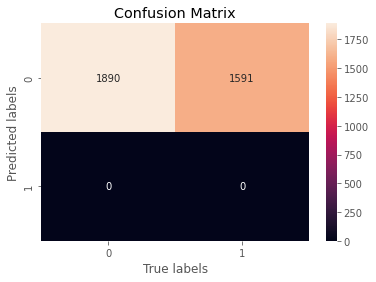

In [580]:
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pred_lis, true_lis, labels=[0,1])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
ax.set_title('Confusion Matrix'); 